# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [6]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

In [8]:
linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 0)

(0.5514447139320511, array([-0.42388312,  0.21194156,  0.21194156]))

In [9]:
linear_classifer.softmax(np.array([1, 0, 0]))

array([0.57611688, 0.21194156, 0.21194156])

In [10]:
np.log(linear_classifer.softmax(np.array([1, 0, 0])))

array([-0.55144471, -1.55144471, -1.55144471])

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [7]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 3
batch_size = 2
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
loss, grads = linear_classifer.softmax_with_cross_entropy(predictions, target_index)

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!


True

In [8]:
delta=1e-5
tol = 1e-4 
z_ = predictions.copy()
it = np.nditer(grads, flags=['multi_index'], op_flags=['readwrite'])

while not it.finished:
    ix = it.multi_index
    print(grads[ix])
    f = lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index)
    
    delta_vec = np.zeros_like(z_)
    delta_vec[ix] += delta
    print('delta', delta_vec, '\n', z_ + delta_vec)
    
    temp1 = f(z_ + delta_vec)[0]
    temp2 = f(z_ - delta_vec)[0]
    print('temp1', temp1, '\ntemp2', temp2)
    print((temp1 - temp2)/(2 * delta), '\n')
    
    it.iternext()

-0.37025176982879043
delta [[1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]] 
 [[ 1.00001  2.      -1.     ]
 [ 1.       1.       2.     ]]
temp1 1.4502247628372245 
temp2 1.4502321678726209
-0.37025176982119484 

0.3526922563491206
delta [[0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00]] 
 [[ 1.       2.00001 -1.     ]
 [ 1.       1.       2.     ]]
temp1 1.4502319922778777 
temp2 1.4502249384327506
0.35269225635570217 

0.017559513479669865
delta [[0.e+00 0.e+00 1.e-05]
 [0.e+00 0.e+00 0.e+00]] 
 [[ 1.       2.      -0.99999]
 [ 1.       1.       2.     ]]
temp1 1.4502286409461007 
temp2 1.450228289755831
0.01755951348769713 

-0.3940292211914573
delta [[0.e+00 0.e+00 0.e+00]
 [1.e-05 0.e+00 0.e+00]] 
 [[ 1.       2.      -1.     ]
 [ 1.00001  1.       2.     ]]
temp1 1.4502245250620822 
temp2 1.4502324056465061
-0.3940292211956908 

0.10597077880854272
delta [[0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00]] 
 [[ 1.       2.      -1.     ]
 [ 1.       1.00001  2.     ]]
temp1 1.450229525

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

In [15]:
X

array([[-1., -1.,  1.],
       [ 0.,  1.,  1.]])

In [16]:
W

array([[ 1.,  2.],
       [-1.,  1.],
       [ 1.,  2.]])

In [13]:
predictions = np.dot(X, W)
predictions

array([[ 1., -1.],
       [ 0.,  3.]])

In [14]:
loss, grads = linear_classifer.linear_softmax(X, W, target_index)
grads

array([[-0.44039854,  0.44039854],
       [-0.4166856 ,  0.4166856 ],
       [ 0.46411148, -0.46411148]])

In [15]:
delta=1e-5
tol = 1e-4 
z_ = W.copy()
it = np.nditer(grads, flags=['multi_index'], op_flags=['readwrite'])

while not it.finished:
    ix = it.multi_index
    print(grads[ix])
    f = lambda w: linear_classifer.linear_softmax(X, w, target_index)
    
    delta_vec = np.zeros_like(z_)
    delta_vec[ix] += delta
    print('delta', delta_vec, '\n', z_ + delta_vec)
    
    temp1 = f(z_ + delta_vec)[0]
    temp2 = f(z_ - delta_vec)[0]
    print('temp1', temp1, '\ntemp2', temp2)
    print((temp1 - temp2)/(2 * delta), '\n')
    
    it.iternext()

-0.44039853898894116
delta [[1.e-05 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]] 
 [[ 1.00001  2.     ]
 [-1.       1.     ]
 [ 1.       2.     ]]
temp1 1.0877532773255922 
temp2 1.087762085296372
-0.4403985389922482 

-0.4166856024001578
delta [[0.e+00 0.e+00]
 [1.e-05 0.e+00]
 [0.e+00 0.e+00]] 
 [[ 1.       2.     ]
 [-0.99999  1.     ]
 [ 1.       2.     ]]
temp1 1.0877535144560875 
temp2 1.0877618481681357
-0.4166856024112597 

0.46411147557772453
delta [[0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [1.e-05 0.e+00]] 
 [[ 1.       2.     ]
 [-1.       1.     ]
 [ 1.00001  2.     ]]
temp1 1.0877623224268673 
temp2 1.0877530401973559
0.4641114755732367 

0.4403985389889412
delta [[0.e+00 1.e-05]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]] 
 [[ 1.       2.00001]
 [-1.       1.     ]
 [ 1.       2.     ]]
temp1 1.087762085296372 
temp2 1.0877532773255922
0.4403985389922482 

0.4166856024001579
delta [[0.e+00 0.e+00]
 [0.e+00 1.e-05]
 [0.e+00 0.e+00]] 
 [[ 1.       2.     ]
 [-1.       1.00001]
 [ 1.       2. 

In [16]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

In [17]:
dW

array([[-0.44039854,  0.44039854],
       [-0.4166856 ,  0.4166856 ],
       [ 0.46411148, -0.46411148]])

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [18]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [19]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.395944
Epoch 1, loss: 2.329967
Epoch 2, loss: 2.309746
Epoch 3, loss: 2.303854
Epoch 4, loss: 2.302685
Epoch 5, loss: 2.303024
Epoch 6, loss: 2.301804
Epoch 7, loss: 2.302362
Epoch 8, loss: 2.301462
Epoch 9, loss: 2.301036


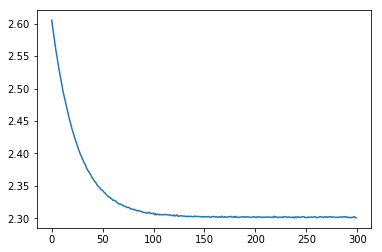

In [20]:
# let's look at the loss history!
plt.plot(loss_history)
plt.show()

In [21]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.119
Epoch 0, loss: 2.301775
Epoch 1, loss: 2.302470
Epoch 2, loss: 2.301517
Epoch 3, loss: 2.302304
Epoch 4, loss: 2.301261
Epoch 5, loss: 2.301431
Epoch 6, loss: 2.302390
Epoch 7, loss: 2.302629
Epoch 8, loss: 2.301360
Epoch 9, loss: 2.301406
Epoch 10, loss: 2.301995
Epoch 11, loss: 2.301792
Epoch 12, loss: 2.302865
Epoch 13, loss: 2.300573
Epoch 14, loss: 2.301694
Epoch 15, loss: 2.301212
Epoch 16, loss: 2.302294
Epoch 17, loss: 2.301142
Epoch 18, loss: 2.301996
Epoch 19, loss: 2.301716
Epoch 20, loss: 2.301361
Epoch 21, loss: 2.302726
Epoch 22, loss: 2.301701
Epoch 23, loss: 2.301551
Epoch 24, loss: 2.302130
Epoch 25, loss: 2.302418
Epoch 26, loss: 2.301620
Epoch 27, loss: 2.301936
Epoch 28, loss: 2.301969
Epoch 29, loss: 2.301542
Epoch 30, loss: 2.301278
Epoch 31, loss: 2.302039
Epoch 32, loss: 2.302859
Epoch 33, loss: 2.303249
Epoch 34, loss: 2.301944
Epoch 35, loss: 2.301846
Epoch 36, loss: 2.302339
Epoch 37, loss: 2.302446
Epoch 38, loss: 2.301568
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [22]:
from tqdm import tqdm
from itertools import product

In [32]:
%%time
num_epochs = 200
batch_size = 300

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr, reg in tqdm(product(learning_rates, reg_strengths)):
    classifier = linear_classifer.LinearSoftmaxClassifier()
    classifier.fit(train_X, train_y, epochs=10, learning_rate=lr, 
                   batch_size=100, reg=reg, random_state=77)
    
    # make prediction on validation
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    print('lr={lr}; reg={reg}'.format(lr=lr, reg=reg))
    print("Accuracy current: ", accuracy, '\n')
    
    if (best_val_accuracy is None) or (best_val_accuracy < accuracy):
        best_val_accuracy = accuracy
        best_classifier = classifier
    
print('best validation accuracy achieved: %f' % best_val_accuracy)

0it [00:00, ?it/s]

Epoch 0, loss: 2.320629
Epoch 1, loss: 2.318327
Epoch 2, loss: 2.250892
Epoch 3, loss: 2.320422
Epoch 4, loss: 2.344472
Epoch 5, loss: 2.302738
Epoch 6, loss: 2.260803
Epoch 7, loss: 2.337542


1it [00:01,  1.27s/it]

Epoch 8, loss: 2.370521
Epoch 9, loss: 2.302183
lr=0.1; reg=0.1
Accuracy current:  0.194 

Epoch 0, loss: 2.255254
Epoch 1, loss: 2.243471
Epoch 2, loss: 2.119944
Epoch 3, loss: 2.210616
Epoch 4, loss: 2.269949
Epoch 5, loss: 2.230083
Epoch 6, loss: 2.144227
Epoch 7, loss: 2.257822


2it [00:02,  1.27s/it]

Epoch 8, loss: 2.316976
Epoch 9, loss: 2.195097
lr=0.1; reg=0.01
Accuracy current:  0.231 

Epoch 0, loss: 2.241433
Epoch 1, loss: 2.219125
Epoch 2, loss: 2.074873
Epoch 3, loss: 2.164472
Epoch 4, loss: 2.228727
Epoch 5, loss: 2.182492
Epoch 6, loss: 2.082369
Epoch 7, loss: 2.199011


3it [00:03,  1.26s/it]

Epoch 8, loss: 2.266523
Epoch 9, loss: 2.129244
lr=0.1; reg=0.001
Accuracy current:  0.243 

Epoch 0, loss: 2.239910
Epoch 1, loss: 2.216210
Epoch 2, loss: 2.069259
Epoch 3, loss: 2.158252
Epoch 4, loss: 2.222558
Epoch 5, loss: 2.174899
Epoch 6, loss: 2.072488
Epoch 7, loss: 2.188826


4it [00:04,  1.25s/it]

Epoch 8, loss: 2.256627
Epoch 9, loss: 2.116913
lr=0.1; reg=0.0001
Accuracy current:  0.243 

Epoch 0, loss: 2.290288
Epoch 1, loss: 2.285788
Epoch 2, loss: 2.242009
Epoch 3, loss: 2.266892
Epoch 4, loss: 2.268025
Epoch 5, loss: 2.264731
Epoch 6, loss: 2.242921
Epoch 7, loss: 2.286863


5it [00:06,  1.25s/it]

Epoch 8, loss: 2.272821
Epoch 9, loss: 2.257251
lr=0.01; reg=0.1
Accuracy current:  0.221 

Epoch 0, loss: 2.284694
Epoch 1, loss: 2.275619
Epoch 2, loss: 2.217788
Epoch 3, loss: 2.238871
Epoch 4, loss: 2.235774
Epoch 5, loss: 2.228667
Epoch 6, loss: 2.188066
Epoch 7, loss: 2.245489


6it [00:07,  1.25s/it]

Epoch 8, loss: 2.219175
Epoch 9, loss: 2.189423
lr=0.01; reg=0.01
Accuracy current:  0.228 

Epoch 0, loss: 2.284011
Epoch 1, loss: 2.274233
Epoch 2, loss: 2.214437
Epoch 3, loss: 2.234558
Epoch 4, loss: 2.230356
Epoch 5, loss: 2.222087
Epoch 6, loss: 2.178171
Epoch 7, loss: 2.236695


7it [00:08,  1.29s/it]

Epoch 8, loss: 2.207737
Epoch 9, loss: 2.174903
lr=0.01; reg=0.001
Accuracy current:  0.228 

Epoch 0, loss: 2.283941
Epoch 1, loss: 2.274090
Epoch 2, loss: 2.214089
Epoch 3, loss: 2.234105
Epoch 4, loss: 2.229780
Epoch 5, loss: 2.221380
Epoch 6, loss: 2.177108
Epoch 7, loss: 2.235730


8it [00:10,  1.31s/it]

Epoch 8, loss: 2.206479
Epoch 9, loss: 2.173302
lr=0.01; reg=0.0001
Accuracy current:  0.228 

Epoch 0, loss: 2.302513
Epoch 1, loss: 2.301632
Epoch 2, loss: 2.291294
Epoch 3, loss: 2.294453
Epoch 4, loss: 2.293231
Epoch 5, loss: 2.294249
Epoch 6, loss: 2.286263
Epoch 7, loss: 2.288891


9it [00:11,  1.30s/it]

Epoch 8, loss: 2.288397
Epoch 9, loss: 2.289214
lr=0.001; reg=0.1
Accuracy current:  0.184 

Epoch 0, loss: 2.299759
Epoch 1, loss: 2.298883
Epoch 2, loss: 2.288258
Epoch 3, loss: 2.291358
Epoch 4, loss: 2.289984
Epoch 5, loss: 2.290865
Epoch 6, loss: 2.282095
Epoch 7, loss: 2.284748


10it [00:12,  1.33s/it]

Epoch 8, loss: 2.283662
Epoch 9, loss: 2.284324
lr=0.001; reg=0.01
Accuracy current:  0.185 

Epoch 0, loss: 2.299474
Epoch 1, loss: 2.298589
Epoch 2, loss: 2.287924
Epoch 3, loss: 2.291008
Epoch 4, loss: 2.289608
Epoch 5, loss: 2.290464
Epoch 6, loss: 2.281602
Epoch 7, loss: 2.284245


11it [00:14,  1.29s/it]

Epoch 8, loss: 2.283082
Epoch 9, loss: 2.283715
lr=0.001; reg=0.001
Accuracy current:  0.186 

Epoch 0, loss: 2.299445
Epoch 1, loss: 2.298559
Epoch 2, loss: 2.287890
Epoch 3, loss: 2.290973
Epoch 4, loss: 2.289570
Epoch 5, loss: 2.290423
Epoch 6, loss: 2.281551
Epoch 7, loss: 2.284194


12it [00:15,  1.29s/it]

Epoch 8, loss: 2.283023
Epoch 9, loss: 2.283653
lr=0.001; reg=0.0001
Accuracy current:  0.186 

Epoch 0, loss: 2.306516
Epoch 1, loss: 2.306047
Epoch 2, loss: 2.302992
Epoch 3, loss: 2.303013
Epoch 4, loss: 2.304494
Epoch 5, loss: 2.304244
Epoch 6, loss: 2.302696
Epoch 7, loss: 2.302279


13it [00:16,  1.28s/it]

Epoch 8, loss: 2.302158
Epoch 9, loss: 2.303320
lr=0.0001; reg=0.1
Accuracy current:  0.132 

Epoch 0, loss: 2.303722
Epoch 1, loss: 2.303264
Epoch 2, loss: 2.300207
Epoch 3, loss: 2.300234
Epoch 4, loss: 2.301734
Epoch 5, loss: 2.301487
Epoch 6, loss: 2.299932
Epoch 7, loss: 2.299523


14it [00:17,  1.29s/it]

Epoch 8, loss: 2.299394
Epoch 9, loss: 2.300577
lr=0.0001; reg=0.01
Accuracy current:  0.133 

Epoch 0, loss: 2.303442
Epoch 1, loss: 2.302984
Epoch 2, loss: 2.299926
Epoch 3, loss: 2.299952
Epoch 4, loss: 2.301453
Epoch 5, loss: 2.301206
Epoch 6, loss: 2.299648
Epoch 7, loss: 2.299240


15it [00:19,  1.30s/it]

Epoch 8, loss: 2.299108
Epoch 9, loss: 2.300293
lr=0.0001; reg=0.001
Accuracy current:  0.133 

Epoch 0, loss: 2.303414
Epoch 1, loss: 2.302956
Epoch 2, loss: 2.299897
Epoch 3, loss: 2.299924
Epoch 4, loss: 2.301425
Epoch 5, loss: 2.301178
Epoch 6, loss: 2.299620
Epoch 7, loss: 2.299211


16it [00:20,  1.30s/it]

Epoch 8, loss: 2.299080
Epoch 9, loss: 2.300265
lr=0.0001; reg=0.0001
Accuracy current:  0.133 

best validation accuracy achieved: 0.243000
CPU times: user 2min 14s, sys: 1min 46s, total: 4min 1s
Wall time: 20.6 s


# Какой же точности мы добились на тестовых данных?

In [33]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.204000
